In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, *paths):
        self.datasets = [datasets.ImageFolder(root=path) for path in paths]
        
        all_classes = sorted(set(cls for ds in self.datasets for cls in ds.classes))
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
        self.classes = all_classes
        
        self.imgs = []
        for ds in self.datasets:
            for img_path, target in ds.imgs:
                new_target = self.class_to_idx[ds.classes[target]]
                self.imgs.append((img_path, new_target))
        
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')  
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
data_dir1 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'
data_dir2 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
data_dir3 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'


custom_dataset = CustomImageFolderDataset(data_dir1, data_dir2, data_dir3)

In [4]:
custom_dataset.class_to_idx

{'all': 0, 'hem': 1}

In [5]:
custom_dataset.classes

['all', 'hem']

In [6]:
custom_dataset.imgs[0]

('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_11_10_1_all.bmp',
 0)

In [7]:
custom_dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [8]:
len(custom_dataset)

10661

In [9]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(custom_dataset, [train_ratio, 1-train_ratio])

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [11]:
len(train_data), len(val_data)

(8529, 2132)

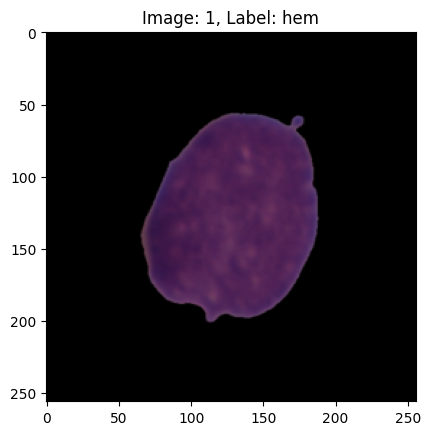

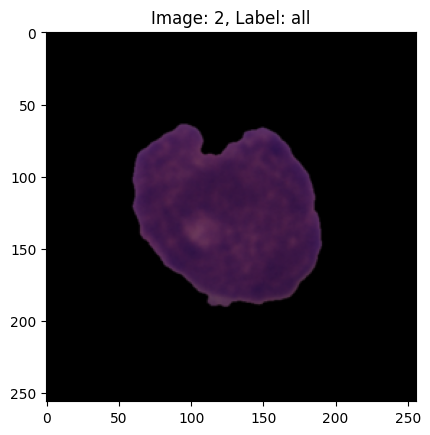

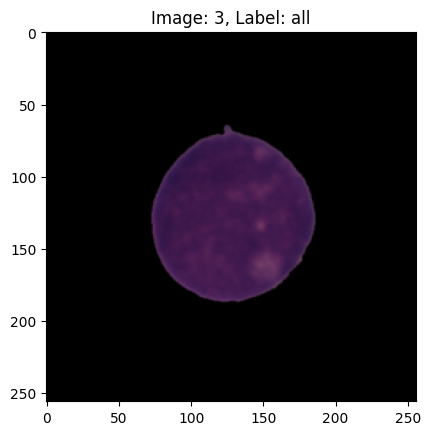

In [12]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = custom_dataset.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()